Overview
The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

<h2>Data Dictionary</h2>
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

<h2>Variable Notes</h2>

<b>pclass</b>: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

<b>age</b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

<b>sibsp</b>: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

<b>parch</b>: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = train.drop(['Survived'], axis=1)
PassengerId = test['PassengerId']
dfg = train.copy()
dfg = dfg.drop(['PassengerId'], axis=1)

In [320]:
y_train = train['Survived']
train_num = len(train)
clf = LogisticRegression(solver='lbfgs', max_iter =200)
gbc = GradientBoostingClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

In [321]:
print(f'''{len(df.columns)} features in dataset. 
Features: {df.columns.values}''')

11 features in dataset. 
Features: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [322]:
df = pd.concat([df,test],ignore_index=True)
df.shape

(1309, 11)

In [323]:
df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [324]:
# dfg.info()
f_name = dfg.columns.tolist()
print(f_name)
del f_name[2]
del f_name[7]
f_name

['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Cabin',
 'Embarked']

In [325]:
# Graph Survical Probability
def graph_survive_prob(df, feature):
    for i in feature[1:]:
        parch_g = sns.catplot(x=i,y='Survived',data=df, kind ='bar')
        parch_g.set_ylabels('Survived Probability')
        plt.ylim(0,1)
        plt.show()

# Ticket Column modification
def ticket_mod(df):
    Ticket = []
    for i in df['Ticket']:
        if not i.isdigit():
            Ticket.append(i.replace("/","").replace(".","").strip().split(" ")[0])
        else:
            Ticket.append("X")
    df['Ticket'] = Ticket
    
# Title Modifiacation
def title_mod(df):
    df['title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    title_group = {
 'Mr':'Mr',
 'Miss':'Miss',
 'Mrs':'Mrs',
 'Master':'upper',
 'Dr':'upper',
 'Rev':'soldier',
 'Col':'soldier',
 'Mlle':'Miss',
 'Ms':'Mrs',
 'Major':'soldier',
 'Don':'royal',
 'Jonkheer':'royal',
 'Mme':'Mrs',
 'Sir':'soldier',
 'Lady':'royal',
 'the Countess':'royal',
 'Dona':'royal',
 'Capt':'soldier'
}
    df['title'] = df['title'].map(title_group)

#Cabin Modificaiton
def cabin_mod(df):
    df["Cabin"] = df['Cabin'].fillna('U')
    df["Cabin"]  =df['Cabin'].apply(lambda x: x[0])

In [326]:
ticket_mod(df)
title_mod(df)
cabin_mod(df)
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A5,7.2500,U,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC,71.2833,C,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STONO2,7.9250,U,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,X,53.1000,C,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,X,8.0500,U,S,Mr


In [327]:
dfg['title'] = dfg['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
dfg['Cabin'] = dfg['Cabin'].fillna('U')
dfg['Cabin'] = dfg['Cabin'].apply(lambda x: x[0])
dfg['fsize'] = dfg['SibSp'] + dfg['Parch'] +1
dfg['age_group'] =pd.cut(dfg['Age'],[0,15,60,80])
f_name.remove('Ticket')
f_name = f_name + ['title', 'fsize','age_group']

In [328]:
dfg['age_group'].value_counts()

(15, 60]    609
(0, 15]      83
(60, 80]     22
Name: age_group, dtype: int64

In [329]:
obj_features = []
num_features = []
for dtype,feature in zip(df.dtypes, df.columns):
    if dtype == 'object':
        obj_features.append(feature)
    else:
        num_features.append(feature)
print(f'''Object Features: {obj_features}
Numeric Features: {num_features}''')

Object Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'title']
Numeric Features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [330]:
group3 = df.groupby(['Sex','Pclass','title'])
group3['Age'].median()

Sex     Pclass  title  
female  1       Miss       30.0
                Mrs        45.0
                royal      39.0
                upper      49.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Mr         41.5
                royal      39.0
                soldier    52.5
                upper      13.0
        2       Mr         30.0
                soldier    41.5
                upper       2.0
        3       Mr         26.0
                upper       6.0
Name: Age, dtype: float64

In [331]:
# Fill NA
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Age'] =group3['Age'].apply(lambda x: x.fillna(x.median()))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


In [332]:
df['Age_group'] = pd.cut(df['Age'], [0,15,60,80])
df['fsize'] = df['SibSp'] + df['Parch'] +1

In [333]:
df['f_1'] = df['fsize'].map(lambda x : 1 if x ==1 else 0)
df['f_2'] = df['fsize'].map(lambda x : 1 if x ==2 else 0)
df['f_med'] = df['fsize'].map(lambda x : 1 if 2 < x <=4 else 0)
df['f_large'] = df['fsize'].map(lambda x : 1 if x > 4 else 0)

In [334]:
df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,Age_group,fsize,f_1,f_2,f_med,f_large
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A5,7.2500,U,S,Mr,"(15, 60]",2,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC,71.2833,C,C,Mrs,"(15, 60]",2,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STONO2,7.9250,U,S,Miss,"(15, 60]",1,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,X,53.1000,C,S,Mrs,"(15, 60]",2,0,1,0,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,X,8.0500,U,S,Mr,"(15, 60]",1,1,0,0,0
5,6,3,"Moran, Mr. James",male,26.0,0,0,X,8.4583,U,Q,Mr,"(15, 60]",1,1,0,0,0
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,X,51.8625,E,S,Mr,"(15, 60]",1,1,0,0,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,X,21.0750,U,S,upper,"(0, 15]",5,0,0,0,1
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,X,11.1333,U,S,Mrs,"(15, 60]",3,0,0,1,0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,X,30.0708,U,C,Mrs,"(0, 15]",2,0,1,0,0


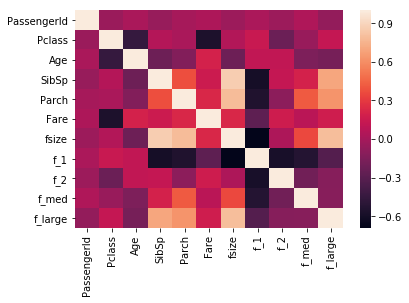

In [335]:
corr = df.corr()
sns.heatmap(corr)
plt.show()
# sns.pairplot(df)
# plt.show()

In [336]:
features = df.columns.tolist()
features

['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'title',
 'Age_group',
 'fsize',
 'f_1',
 'f_2',
 'f_med',
 'f_large']

In [337]:
df=df.drop(['PassengerId','Name','Age','Parch','SibSp','fsize'], axis=1)
        

In [338]:
df['Fare']= MinMaxScaler().fit_transform(df['Fare'].values.reshape(-1,1))

df.columns.tolist()


['Pclass',
 'Sex',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'title',
 'Age_group',
 'f_1',
 'f_2',
 'f_med',
 'f_large']

In [339]:
features = df.columns.tolist()
features.pop(3)
features

['Pclass',
 'Sex',
 'Ticket',
 'Cabin',
 'Embarked',
 'title',
 'Age_group',
 'f_1',
 'f_2',
 'f_med',
 'f_large']

In [340]:
for i in features[:7]:
    df = df.join(pd.get_dummies(df[i],prefix=i))

In [341]:
df = df.drop(features[:7],axis=1)

In [345]:
df.columns.tolist()

['Fare',
 'f_1',
 'f_2',
 'f_med',
 'f_large',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Ticket_A',
 'Ticket_A4',
 'Ticket_A5',
 'Ticket_AQ3',
 'Ticket_AQ4',
 'Ticket_AS',
 'Ticket_C',
 'Ticket_CA',
 'Ticket_CASOTON',
 'Ticket_FC',
 'Ticket_FCC',
 'Ticket_Fa',
 'Ticket_LINE',
 'Ticket_LP',
 'Ticket_PC',
 'Ticket_PP',
 'Ticket_PPP',
 'Ticket_SC',
 'Ticket_SCA3',
 'Ticket_SCA4',
 'Ticket_SCAH',
 'Ticket_SCOW',
 'Ticket_SCPARIS',
 'Ticket_SCParis',
 'Ticket_SOC',
 'Ticket_SOP',
 'Ticket_SOPP',
 'Ticket_SOTONO2',
 'Ticket_SOTONOQ',
 'Ticket_SP',
 'Ticket_STONO',
 'Ticket_STONO2',
 'Ticket_STONOQ',
 'Ticket_SWPP',
 'Ticket_WC',
 'Ticket_WEP',
 'Ticket_X',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'title_royal',
 'title_soldier',
 'title_upper',
 'Age_group_(0, 15]',
 'Age_group_(15, 60]',
 'Age_group_(60, 80]']

In [167]:
X_train = df[:train_num]
X_test = df[train_num:]

In [346]:
X_test.describe()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,...,"Age_group_(15, 80]",fsize_1,fsize_2,fsize_3,fsize_4,fsize_5,fsize_6,fsize_7,fsize_8,fsize_11
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.255981,0.222488,0.521531,0.363636,0.636364,0.002392,0.007177,0.016746,0.002392,0.002392,...,0.913876,0.605263,0.177033,0.136364,0.033493,0.016746,0.007177,0.009569,0.004785,0.009569
std,0.436934,0.416416,0.500135,0.481622,0.481622,0.048912,0.084514,0.128474,0.048912,0.048912,...,0.280884,0.489380,0.382154,0.343586,0.180135,0.128474,0.084514,0.097471,0.069088,0.097471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [87]:
# cross_val_score(clf,X_train, y_train, cv=5).mean()

In [88]:
# cross_val_score(gbc,X_train, y_train, cv=10).mean()

In [89]:
# cross_val_score(dtc,X_train,y_train, cv=10).mean()

In [90]:
# cross_val_score(rfc,X_train,y_train, cv=10).mean()

In [350]:
parameters = dict(
    max_depth =[i for i in range(7,20)],
    min_samples_split = [i for i in range (4,15)],
    min_samples_leaf = [i for i in range (2,5)],
    n_estimators = [i for i in range(10,50,10)],

)


In [351]:
rfc_cv = GridSearchCV(estimator=rfc,
                     param_grid = parameters, cv=5)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'min_samples_split': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_leaf': [2, 3, 4], 'n_estimators': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [352]:
print(f'Best Score: {rfc_cv.best_score_}')
print(f'Best Parameters: {rfc_cv.best_estimator_}')

Best Score: 0.8316498316498316
Best Parameters: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [353]:
prediction = rfc_cv.predict(X_test)

In [354]:
result = pd.DataFrame({'PassengerId': PassengerId,
                       'Survived': prediction})
result.to_csv('./titanic_submission.csv', index=False)